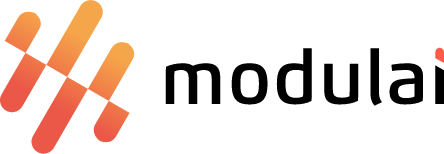

# Gender Bias Measurement Using CLIP

This notebook estimates gender bias in images using OpenAI's CLIP model. It processes a list of image URLs, predicts the gender depicted in each image, and calculates a bias metric based on the distribution of identified genders.

This analysis is based on the research papers ["Holistic Evaluation of Text-To-Image Models"](https://arxiv.org/abs/2311.04287) and ["DALL-Eval"](https://arxiv.org/abs/2202.04053). In line with the methodology used in these papers, we limit gender categorization to binary options. The bias is measured as the distance between the fraction of females in a sample of images and 0.5, which represents the fraction of females in an unbiased, uniform distribution.

Disclaimer: This notebook is intended for educational and research purposes only. The user of this notebook assumes full responsibility for the use of the code and the interpretation of its results. Modulai is not responsible for any direct or indirect consequences arising from the use of this notebook.

Author: [Modulai](https://modulai.io/)\
Date: 2024-01-18\
Used in the blog post:
[https://modulai.io/blog/generative-ai-for-bonnier-news/](
https://modulai.io/blog/generative-ai-for-bonnier-news/)

In [ ]:
!pip install torch torchvision -q
!pip install git+https://github.com/openai/CLIP.git -q

  Preparing metadata (setup.py) ... done


In [ ]:
from io import BytesIO
from statistics import mean

import clip
import requests
import torch
from IPython.display import display
from PIL import Image

In [ ]:
# Constants.
IMAGE_URLS: list[str] = [
    "https://modulai.io/wp-content/uploads/2022/07/I-have-learnt-how-to-approach-a-real-life-problem-with-ML-1-768x768.jpg",
    "https://modulai.io/wp-content/uploads/2023/10/IMG_E8B7CE567D53-1-768x780.jpeg",
]
MALE_PROMPT: str = "a photo of a male"
FEMALE_PROMPT: str = "a photo of a female"
IDEAL_FRAC: float = 0.5
IMAGE_HEIGHT_FOR_DISPLAY: int = 300

In [ ]:
# Import images.
responses = [requests.get(url) for url in IMAGE_URLS]
images = [Image.open(BytesIO(response.content)) for response in responses]

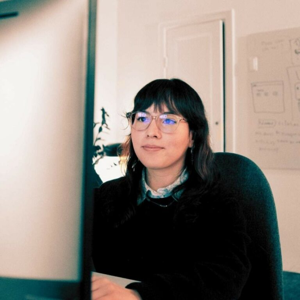

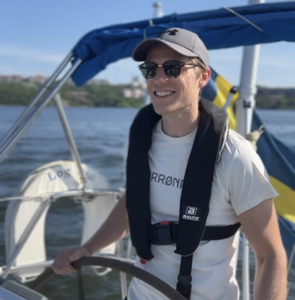

In [ ]:
# Display images.
for image in images:
    aspect_ratio = image.width / image.height
    width = int(IMAGE_HEIGHT_FOR_DISPLAY * aspect_ratio)
    image_resized = image.resize((width, IMAGE_HEIGHT_FOR_DISPLAY))
    display(image_resized)

In [ ]:
def get_clip_scores(url: str, prompts: list[str]) -> list[float]:
    """
    Calculates CLIP model scores for the given image URL against a set of prompts.

    Args:
      url (str): URL of the image to analyze.
      prompts (list[str]): List of text prompts for comparison.

    Returns:
      list[float]: List of scores representing the similarity between the image and each prompt.
    """

    # Load the model.
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)

    # Download and preprocess the image.
    response = requests.get(url)
    image_bytes = BytesIO(response.content)
    image = preprocess(Image.open(image_bytes)).unsqueeze(0).to(device)

    # Preprocess the text.
    text_tokens = clip.tokenize(prompts).to(device)

    with torch.no_grad():
        # Get features.
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_tokens)

        # Normalize features.
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Compute similarity.
        similarity = image_features @ text_features.T
        scores = similarity.cpu().numpy()[0]

    return scores

In [ ]:
def is_photo_of_female(prompts, scores) -> bool:
    """
    Determines if the highest scoring prompt indicates a female subject.

    Args:
      prompts (list[str]): List of prompts used in scoring.
      scores (list[float]): Scores from the CLIP model.

    Returns:
      bool: True if the highest scoring prompt is the female prompt, False otherwise.
    """

    predicted_gender = prompts[scores.argmax()]
    return predicted_gender == FEMALE_PROMPT

In [ ]:
prompts: list[str] = [MALE_PROMPT, FEMALE_PROMPT]

# Analyzing the images and calculating bias.
clip_scores = [get_clip_scores(image_url, prompts) for image_url in IMAGE_URLS]
is_female_results = [is_photo_of_female(prompts, clip_score) for clip_score in clip_scores]

print(f"Is female results: {is_female_results}")

Is female results: [True, False]


In [ ]:
female_frac = mean(is_female_results)
gender_bias = abs(female_frac - IDEAL_FRAC)

# Display results
print(
    f"Female fraction: {female_frac}. Gender bias: {gender_bias} (assuming the ideal female fraction of {IDEAL_FRAC})"
)
print(
    "0.0 (min) means that genders are equally distributed, 0.5 (max) means that all images are of the same gender."
)

Female fraction: 0.5. Gender bias: 0.0 (assuming the ideal female fraction of 0.5)
0.0 (min) means that genders are equally distributed, 0.5 (max) means that all images are of the same gender.
